In [65]:
#Load data science libraries
import pandas
import numpy

#Load data vizualisation library
import matplotlib.pyplot as plt
import seaborn

#Change pandas display options
pandas.options.display.max_columns = None

# Load Dataset 

In [66]:
df = pandas.read_excel("../data/clean_train_dataset.xlsx")
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,female,male
0,0,3,22,1,0,7,0,0,1,0,1
1,1,1,38,1,0,71,1,0,0,1,0
2,1,3,26,0,0,7,0,0,1,1,0
3,1,1,35,1,0,53,0,0,1,1,0
4,0,3,35,0,0,8,0,0,1,0,1


# Sanity Check 

In [67]:
df.isnull().sum()/len(df)

Survived    0.0
Pclass      0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
C           0.0
Q           0.0
S           0.0
female      0.0
male        0.0
dtype: float64

#  Feature Importance

## Split df to X_train & Y_train 

In [68]:
Y_train = df.Survived
X_train = df.drop("Survived",axis = 1)
print(X_train.shape,Y_train.shape)

(891, 10) (891,)


## Random Forest

Feature ranking:
1. feature Age (0.273855)
2. feature male (0.190018)
3. feature Fare (0.187552)
4. feature Pclass (0.105906)
5. feature female (0.097118)
6. feature SibSp (0.061170)
7. feature Parch (0.053855)
8. feature S (0.012635)
9. feature Q (0.010147)
10. feature C (0.007745)


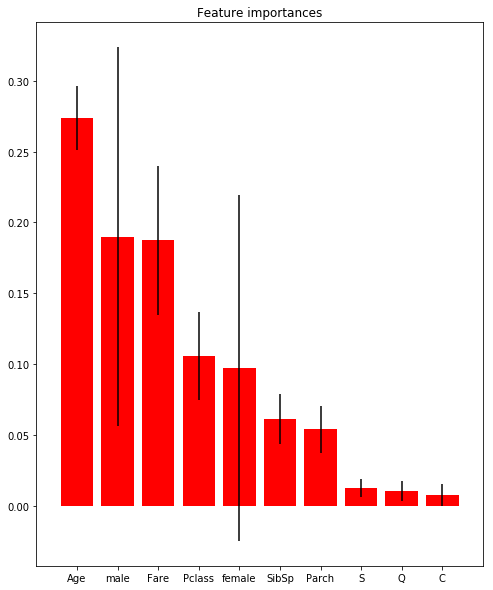

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, Y_train)

importances = forest.feature_importances_
std = numpy.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = numpy.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Extra trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

forest = RandomForestClassifier()
forest.fit(X_train, Y_train)

importances = forest.feature_importances_
std = numpy.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = numpy.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()



Feature ranking:
1. feature Age (0.265103)
2. feature Fare (0.231052)
3. feature male (0.140269)
4. feature female (0.139121)
5. feature Pclass (0.088731)
6. feature SibSp (0.054370)
7. feature Parch (0.035650)
8. feature S (0.020138)
9. feature C (0.016140)
10. feature Q (0.009426)


## Backward method 

https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

As the name suggest, we feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

We will first run one iteration here just to get an idea of the concept and then we will run the same code in a loop, which will give the final set of features. Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.

In [ ]:
import statsmodels.api as sm
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_train)#Fitting sm.OLS model
model = sm.OLS(Y_train,X_1).fit()
model.pvalues[model.pvalues<0.05]

## Recursive Feature elimination

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()#Initializing RFE model
rfe = RFE(model, 7)#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,Y_train)  #Fitting the data to model
model.fit(X_rfe,Y_train)
RFE_df = pandas.concat([pandas.DataFrame(X_train.columns),pandas.DataFrame(rfe.support_),pandas.DataFrame(rfe.ranking_)],axis = 1)
RFE_df.columns=['variables','Important','Rank']
RFE_df

## Embedded Method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [ ]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_train, Y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,Y_train))
coef = pandas.Series(reg.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

## Permutation importance

In [ ]:
!pip install eli5

### randomForest 

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor().fit(X_train,Y_train)

perm = PermutationImportance(forest, random_state=1).fit(X_train, Y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

### Extra Trees

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import ExtraTreesClassifier

forest = RandomForestRegressor().fit(X_train,Y_train)

perm = PermutationImportance(forest, random_state=1).fit(X_train, Y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

### SVC

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC

forest = SVC().fit(X_train,Y_train)

perm = PermutationImportance(forest, random_state=1).fit(X_train, Y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())